# Computational Physics Blatt 03
Anne, Fabian und Asliddin 

In [42]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import matplotlib
import timeit

matplotlib.rcParams["figure.figsize"] = (10, 10)
%matplotlib inline

cmap = plt.get_cmap("viridis") # our default time scale
S_PLANET = 75000 # Plot size of the planet in a 4x4 unit plot
# Set some constants
T0 = 0
T_MAX = 100
H = 0.001
DIM = 3 # Number of dimensions, relevant for the indeces of y


def gravitation(delta_r, m1, m2, G=1):
    return -G * m1 * m2 * delta_r / norm(delta_r)**3


def graviWrap(t, y, m1=1, m2=1e-10, G=1):
    # Splitting the vector y into the four vectors r1, r2, p1, p2
    r1 = y[0:DIM]
    r2 = y[DIM : 2 * DIM]
    p1 = y[2 * DIM : 3 * DIM]
    p2 = y[3 * DIM : 4 * DIM]

    delta_r = r2 - r1
    p2_dot = gravitation(delta_r, m1, m2, G=G)
    p1_dot = -p2_dot
    r1_dot = p1 / m1
    r2_dot = p2 / m2
    
    return np.concatenate((r1_dot, r2_dot, p1_dot, p2_dot))

In [43]:
def rungeKutta4(
    f, y0, t0, h, t_max, **kwargs
):  # Generator for the recursive Runge-Kutta 4th order method.
    y = y0
    t_n = t0
    t_n1 = t_n + h  # in Latex: t_{n+1}
    t_n12 = t_n + h / 2  # in Latex: t_{n+1/2}
    while t_n < t_max:
        k1 = h * f(t_n, y, **kwargs)
        k2 = h * f(t_n12, y + 0.5 * k1, **kwargs)
        k3 = h * f(t_n12, y + 0.5 * k2, **kwargs)
        k4 = h * f(t_n1, y + k3, **kwargs)
        y = y + (k1 + 2 * k2 + 2 * k3 + k4) / 6
        t_n = t_n1
        t_n1 = t_n + h
        t_n12 = t_n + h / 2
        yield t_n, y

## a)

The gravitational Force is given by
\begin{align}
    \ddot{r}_\mathrm{i}m_\mathrm{i} &= -G\frac{m_\mathrm{i}m_\mathrm{j}}{\left|r_\mathrm{i}- r_\mathrm{j}\right|^3}(r_\mathrm{i}- r_\mathrm{j}) \\
    \Leftrightarrow \ddot{r}_\mathrm{i} &= -G\frac{m_\mathrm{j}}{\left|r_\mathrm{i}- r_\mathrm{j}\right|^3}(r_\mathrm{i}- r_\mathrm{j}) \\
\end{align}
By using $y = (r,p)^\mathrm{T}$ we can simplify this differential equation of rank 2 to two differential equations of rank 1
\begin{align}
y_\mathrm{i} &= \begin{pmatrix}
    r_\mathrm{i} \\
    p_\mathrm{i}
    \end{pmatrix} \\
\Rightarrow \dot{r}_\mathrm{i} &= \frac{p_\mathrm{i}}{m_\mathrm{i}} \\
\Rightarrow \dot{p_\mathrm{i}} &= -G\frac{m_\mathrm{j}}{\left|r_\mathrm{i}- r_\mathrm{j}\right|^3}(r_\mathrm{i}- r_\mathrm{j}) \\
\end{align}

Text(0.5, 1.0, 'Starting with to low velocity')

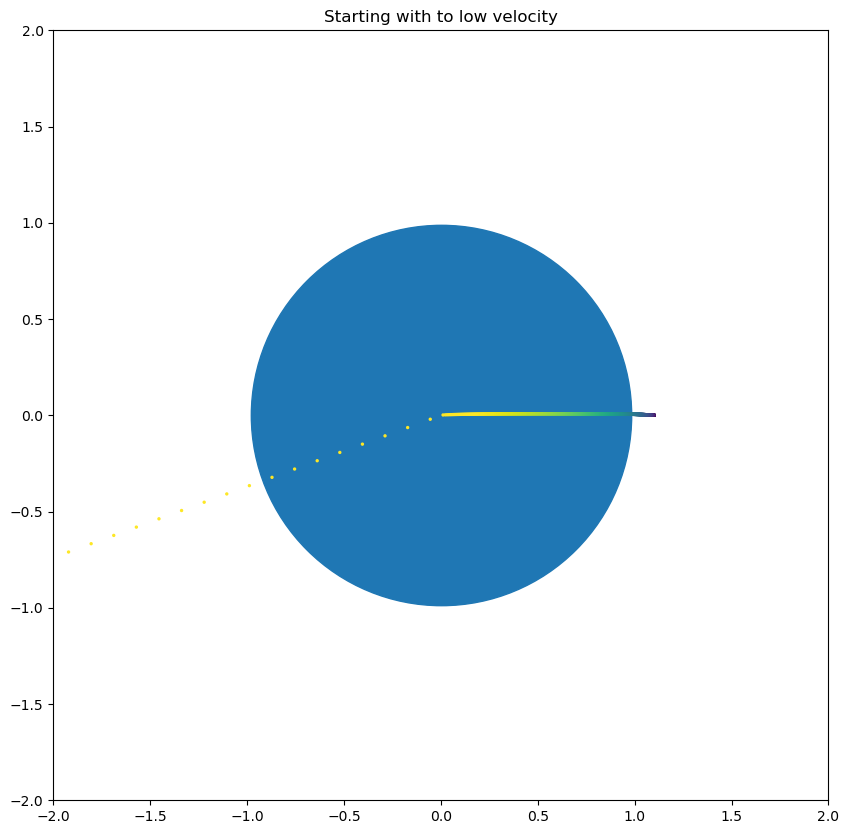

In [44]:
m_Planet = 1
m_RS = 1e-10
r0_Planet = np.array([0, 0, 0])
r0_RS = np.array([1.1, 0, 0])
p0_Planet = np.array([0, 0, 0]) * m_Planet  # p = v * m
p0_RS = np.array([0, 1e-2, 0]) * m_RS


y_slow = np.concatenate((r0_Planet, r0_RS, p0_Planet, p0_RS))
system = rungeKutta4(graviWrap, y_slow, t0=T0, h=H, t_max=T_MAX, m1=m_Planet, m2=m_RS)
run1 = [(t, y) for (t, y) in system]
time, trajectory = zip(*run1)  # Unpacks the tuples of states into two lists
time = np.array(time)
trajectory = np.array(trajectory)
colors = cmap(time / time[:1250].max())
plt.scatter(
    trajectory[0, 0], trajectory[0, 1], s=S_PLANET
)  # Planet is basically stationary, only plot one point
plt.scatter(trajectory[:, 3], trajectory[:, 4], s=2, c=colors)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.title("Starting with to low velocity")

Text(0.5, 1.0, 'Starting with correct velocity')

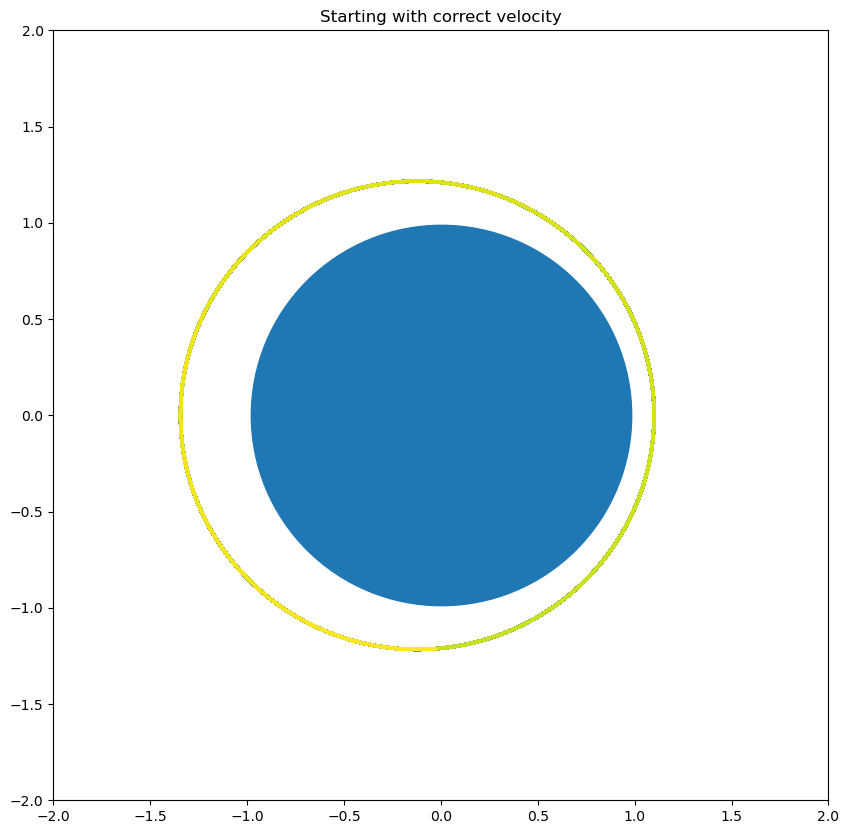

In [45]:
r0_Planet = np.array([0, 0, 0])
r0_RS = np.array([1.1, 0, 0])
p0_Planet = np.array([0, 0, 0]) * m_Planet
p0_RS = np.array([0, 1, 0]) * m_RS


y_0 = np.concatenate((r0_Planet, r0_RS, p0_Planet, p0_RS))
system = rungeKutta4(graviWrap, y_0, t0=T0, h=H, t_max=T_MAX, m1=m_Planet, m2=m_RS)
run2 = [(t, y) for (t, y) in system]
time, trajectory = zip(*run2)
time = np.array(time)
trajectory = np.array(trajectory)
colors = cmap(time / time[-1])
plt.scatter(
    trajectory[0, 0], trajectory[0, 1], s=S_PLANET
)  # Planet is basically stationary, only plot one point
plt.scatter(trajectory[:, 3], trajectory[:, 4], s=2, c=colors)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.title("Starting with correct velocity")

When starting with to little velocity, the space station crashes in the planet, as it should.

In this simulation, the station can pass thru the planet at extreme velocity.
Because our $h$ is to big for this rate of change, we miss the very important moments of big deceleration and the station escapes. 

## d)

In [46]:
def euler(f, y0, t0, h, t_max, **kwargs):
    y = y0
    t_n = t0
    t_n1 = t_n + h
    while t_n < t_max:
        y = y + h * f(t_n, y, **kwargs)
        t_n = t_n1
        t_n1 = t_n + h
        yield t_n, y

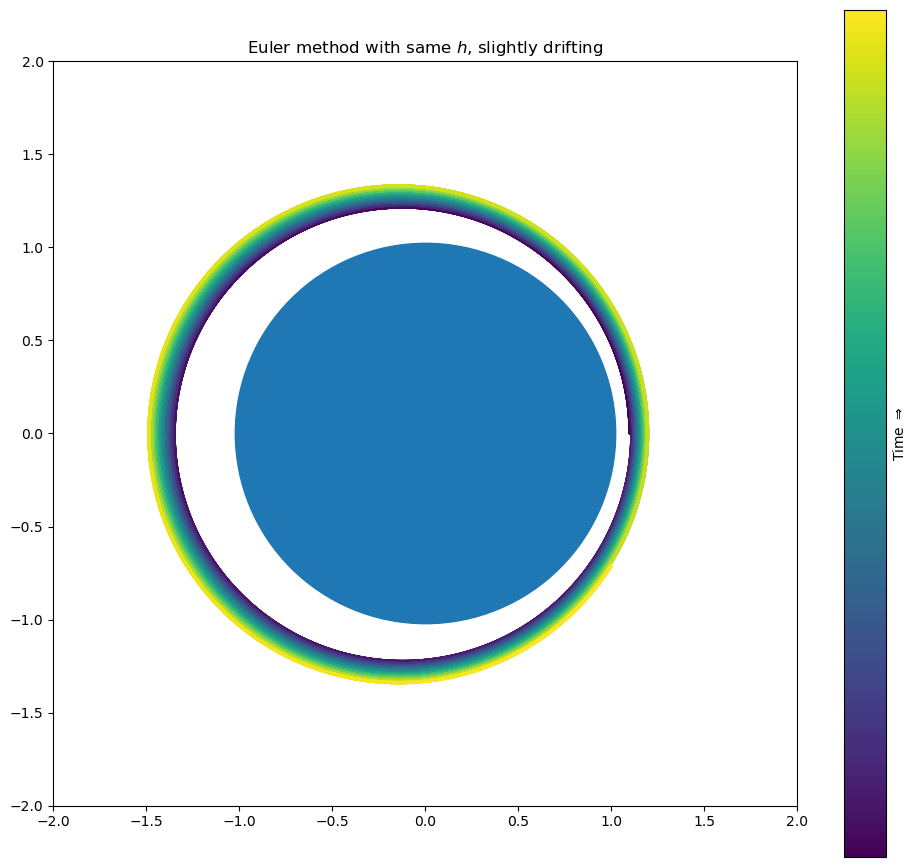

In [47]:
system = euler(graviWrap, y_0, t0=T0, h=H, t_max=T_MAX, m1=m_Planet, m2=m_RS)
eulerRun1 = [(t, y) for (t, y) in system]
time, trajectory = zip(*eulerRun1)
time = np.array(time)
trajectory = np.array(trajectory)

fig, ax = plt.subplots(figsize=(12, 11))
colors = cmap(time / time[-1])
ax.scatter(
    trajectory[0, 0], trajectory[0, 1], s=S_PLANET
)  # Planet is basically stationary, only plot one point
trajPlot = ax.scatter(trajectory[:, 3], trajectory[:, 4], s=2, color=colors)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_title("Euler method with same $h$, slightly drifting")
ax.set_aspect("equal", "box")  # Set 1:1 aspect ratio

# Make pretty colorbar
cbar = fig.colorbar(trajPlot, ax=ax)
cbar.set_label("Time $\Rightarrow$")
cbar.set_ticks([])

Using the $h$ from the Runge-Kutta method shows a slight drift of the station into space. So to compare the methods fairly, we need to decrease our step size.

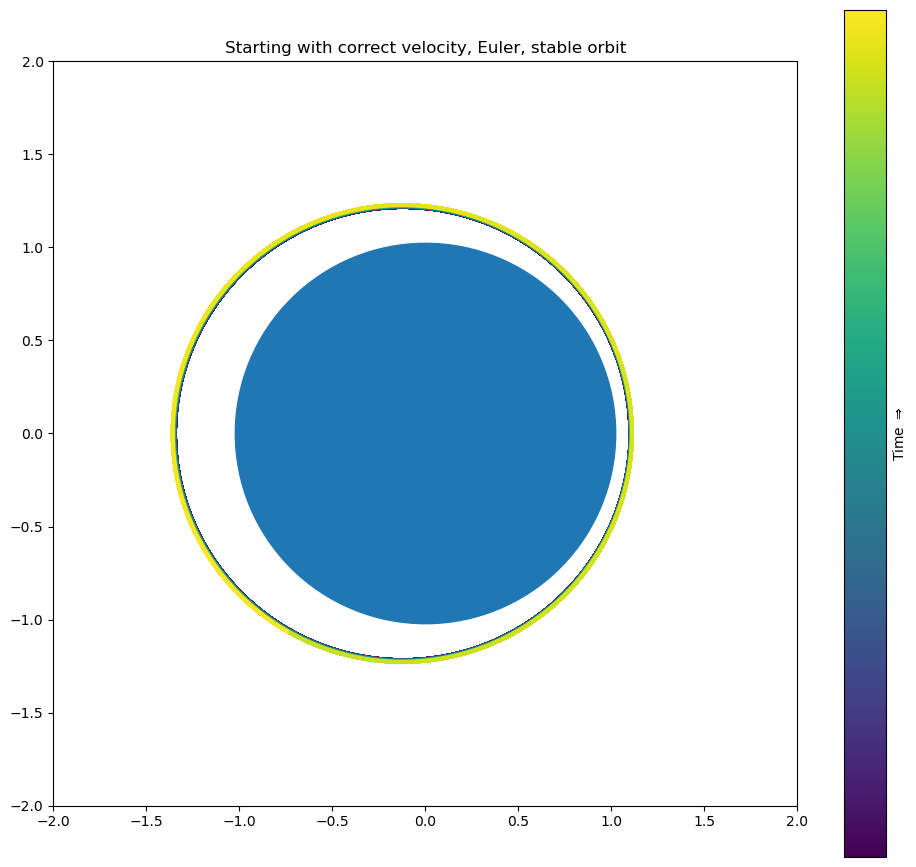

In [48]:
H_EULER = H * 0.1

system = euler(graviWrap, y_0, t0=T0, h=H_EULER, t_max=T_MAX, m1=m_Planet, m2=m_RS)
eulerRun2 = [(t, y) for (t, y) in system]
time, trajectory = zip(*eulerRun2)
time = np.array(time)
trajectory = np.array(trajectory)

fig, ax = plt.subplots(figsize=(12, 11))
colors = cmap(time / time[-1])
ax.scatter(
    trajectory[0, 0], trajectory[0, 1], s=S_PLANET
)  # Planet is basically stationary, only plot one point
trajPlot = ax.scatter(trajectory[:, 3], trajectory[:, 4], s=2, color=colors)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_title("Starting with correct velocity, Euler, stable orbit")
ax.set_aspect("equal", "box")  # Set 1:1 aspect ratio

# Make pretty colorbar
cbar = fig.colorbar(trajPlot, ax=ax)
cbar.set_label("Time $\Rightarrow$")
cbar.set_ticks([])

In [49]:
%%timeit # WARNING: This cell will take a long time to run
system = euler(graviWrap, y_0, t0=T0, h=H_EULER, t_max=T_MAX, m1=m_Planet, m2=m_RS)
eulerRun = [(t, y) for (t, y) in system]
time, trajectory = zip(*eulerRun)
time = np.array(time)
trajectory = np.array(trajectory)


9.44 s ± 14.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
%%timeit # WARNING: This cell will take a long time to run
system = rungeKutta4(graviWrap, y_0, t0=T0, h=H, t_max=T_MAX, m1=m_Planet, m2=m_RS)
rkRun = [(t, y) for (t, y) in system]
time, trajectory = zip(*rkRun)
time = np.array(time)
trajectory = np.array(trajectory)

4.36 s ± 72.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


With the adjusted $h$ for the euler method, it takes about double as long to sun the simulation, 9.81s against 4.43s for the Runge-Kutta method on my maschine.

## e)

We can just use our original run, so we use $N=t_\mathrm{max}/h = 100\,000$ steps, invert all momentum an do another $100\,000$ steps

In [51]:
return_point = np.copy(run2[1][-1])  # Ensure we dont modify the original array
return_point[2 * DIM : 4 * DIM] *= -1  # Invert the momentum of the system

system = rungeKutta4(
    graviWrap, return_point, t0=T_MAX, h=H, t_max=2 * T_MAX, m1=m_Planet, m2=m_RS
)
invertRun = [(t, y) for (t, y) in system]
print(
    f"The system returns to the initial state: {np.allclose(invertRun[1][-1], y_0)}"
)  # Check if the system returns to the initial state
print(f"Difference in y vector: {invertRun[1][-1] - y_0}")

The system returns to the initial state: True
Difference in y vector: [ 9.42935301e-31 -4.85996384e-34  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  3.78653235e-29 -1.67632942e-30
  0.00000000e+00 -3.78653235e-29 -2.00000000e-10 -0.00000000e+00]


## f)

In [59]:
RPlanet = 1


def friction(delta_r, delta_v):
    Cw = 1
    A = 1e-12  # The given Area of 0.001 is waaaay to large in this unit system
    rho0 = 1
    hs = 1.05

    rho = rho0 * np.exp(-np.abs(norm(delta_r) - RPlanet) / hs)
    force_value = -0.5 * rho * norm(delta_v) * Cw * A
    return (
        force_value * delta_v
    )  # because we didnt square the norm of delta_v before, we dont need to divide here


def forceWrap(t, y, m1=1, m2=1e-10, G=1):
    # Splitting the vector y into the four vectors r1, r2, p1, p2
    r1 = y[0:DIM]
    r2 = y[DIM : 2 * DIM]
    p1 = y[2 * DIM : 3 * DIM]
    p2 = y[3 * DIM : 4 * DIM]
    v1 = p1 / m1
    v2 = p2 / m2
    delta_r = r2 - r1
    delta_v = v2 - v1
    p2_dot = gravitation(delta_r, m1, m2, G=G) + friction(delta_r, delta_v)
    p1_dot = -p2_dot
    r1_dot = v1
    r2_dot = v2
    return np.concatenate((r1_dot, r2_dot, p1_dot, p2_dot))


def rungeKutta4Crash(
    f, y0, t0, h, t_max, **kwargs
):  # Generator for the recursive Rubnge-Kutta 4th order method.
    y = y0
    t_n = t0
    t_n1 = t_n + h  # in Latex: t_{n+1}
    t_n12 = t_n + h / 2  # in Latex: t_{n+1/2}
    dist = norm(y[0:DIM] - y[DIM : 2 * DIM])
    while (
        t_n < t_max and dist > RPlanet and dist < 10 * RPlanet
    ):  # while debugging, we want to stop if the distance is too large
        k1 = h * f(t_n, y, **kwargs)
        k2 = h * f(t_n12, y + 0.5 * k1, **kwargs)
        k3 = h * f(t_n12, y + 0.5 * k2, **kwargs)
        k4 = h * f(t_n1, y + k3, **kwargs)
        y = y + (k1 + 2 * k2 + 2 * k3 + k4) / 6
        t_n = t_n1
        t_n1 = t_n + h
        t_n12 = t_n + h / 2
        dist = norm(y[0:DIM] - y[DIM : 2 * DIM])
        yield t_n, y

## g)
We already used the right initial velocity, so we can use our $y_0$.

Text(0.5, 1.0, 'With friction')

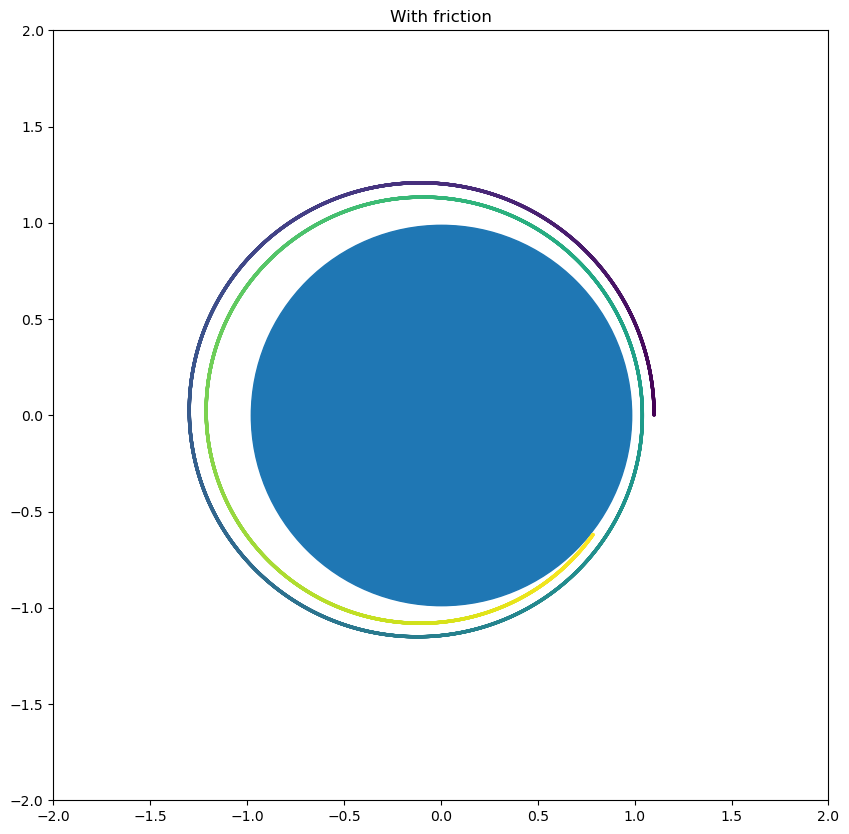

In [60]:
system = rungeKutta4Crash(forceWrap, y_0, t0=T0, h=H, t_max=T_MAX, m1=m_Planet, m2=m_RS)
run3 = [(t, y) for (t, y) in system]
time, trajectory = zip(*run3)  # Unpacks the tuples of states into two lists
time = np.array(time)
trajectory = np.array(trajectory)

colors = cmap(time / time[-1])
plt.scatter(
    trajectory[0, 0], trajectory[0, 1], s=S_PLANET
)  # Planet is basically stationary, only plot one point
plt.scatter(trajectory[:, 3], trajectory[:, 4], s=2, c=colors)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.title("With friction")

In [54]:
print(f"steps until crash: {len(trajectory)}")
print(f"In universe time: {time[-1]}")

steps until crash: 6439
In universe time: 6.439000000000485


## h)

In [61]:
def moonWrap(t, y, m1=1, m2=1e-10, m3=0.02, G=1):
    # Splitting the vector y into the six vectors r1, r2, r3, p1, p2, p3
    r1 = y[0:DIM]
    r2 = y[DIM : 2 * DIM]
    r3 = y[2 * DIM : 3 * DIM]
    p1 = y[3 * DIM : 4 * DIM]
    p2 = y[4 * DIM : 5 * DIM]
    p3 = y[5 * DIM : 6 * DIM]
    delta_r12 = r2 - r1
    delta_r13 = r3 - r1
    delta_r23 = r3 - r2
    grav12 = gravitation(delta_r12, m1, m2, G=G)
    grav13 = gravitation(delta_r13, m1, m3, G=G)
    grav23 = gravitation(delta_r23, m2, m3, G=G)
    p1_dot = -grav12 - grav13
    p2_dot = +grav12 - grav23
    p3_dot = +grav13 + grav23
    r1_dot = p1 / m1
    r2_dot = p2 / m2
    r3_dot = p3 / m3
    return np.concatenate((r1_dot, r2_dot, r3_dot, p1_dot, p2_dot, p3_dot))

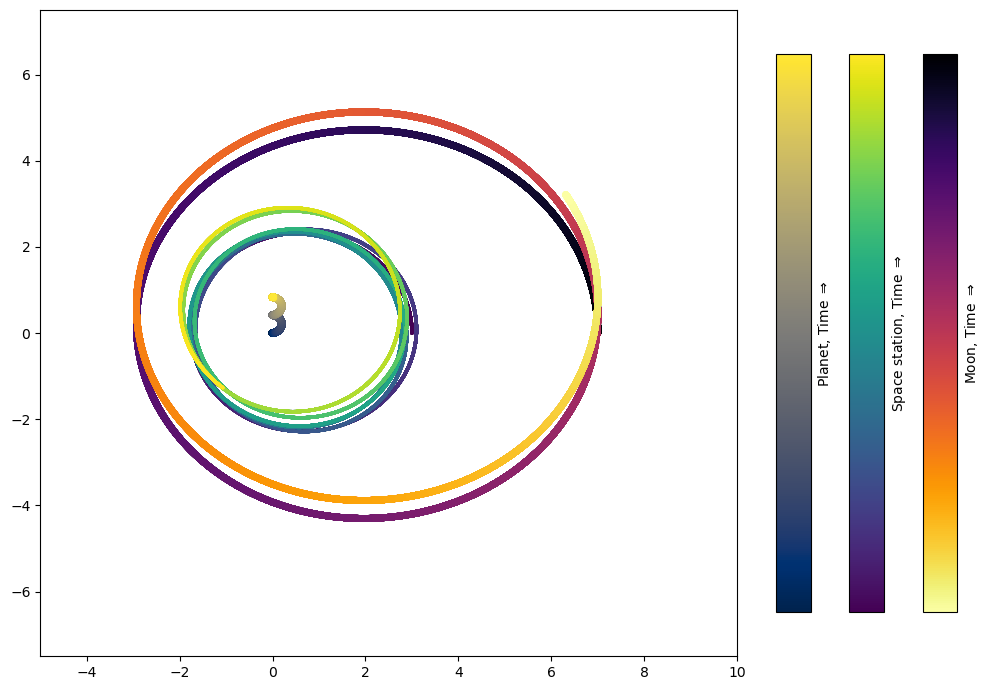

In [62]:
# Setting up the initial conditions
m_moon = 0.02
r0_moon = np.array([7, 0, 0])
p0_moon = np.array([0, 0.3, 0]) * m_moon


r0_RS = np.array([3, 0, 0])
p0_RS = np.array([0, 0.5, 0]) * m_RS

y_moon = np.concatenate((r0_Planet, r0_RS, r0_moon, p0_Planet, p0_RS, p0_moon))

system = rungeKutta4(
    moonWrap, y_moon, t0=T0, h=H, t_max=150, m1=m_Planet, m2=m_RS, m3=m_moon
)
run4 = [(t, y) for (t, y) in system]
time, trajectory = zip(*run4)  # Unpacks the tuples of states into two lists
time = np.array(time)
trajectory = np.array(trajectory)

# Create the figure and the subplots for a quiete complex plot
fig, ax = plt.subplots(
    1, 4, figsize=(10, 7), gridspec_kw={"width_ratios": [1, 0.05, 0.05, 0.05]}
)

time_scaled = time / time[-1]
inferno = plt.get_cmap("inferno")
cividis = plt.get_cmap("cividis")
viridis = plt.get_cmap("viridis")
c_moon = inferno(time_scaled)
c_planet = cividis(time_scaled)
c_rs = viridis(time_scaled)


# Create the scatter plots in the first subplot
ax[0].scatter(trajectory[:, 0], trajectory[:, 1], s=20, c=c_planet)
ax[0].scatter(trajectory[:, 3], trajectory[:, 4], s=2, c=c_rs)
ax[0].scatter(trajectory[:, 6], trajectory[:, 7], s=15, c=c_moon)
ax[0].set_xlim(-5, 10)
ax[0].set_ylim(-7.5, 7.5)

# Create a dummy image for each colorbar
img_planet = plt.imshow(np.array([[-8, 8]]), cmap=cividis)
img_rs = plt.imshow(np.array([[-8, 8]]), cmap=viridis)
img_moon = plt.imshow(np.array([[-8, 8]]), cmap=inferno)
#
# Hide the dummy images
img_planet.set_visible(False)
img_rs.set_visible(False)
img_moon.set_visible(False)

# Set the aspect ratio of the axes that the colorbars are drawn in
ax[1].set_aspect(1)
ax[2].set_aspect(1)
ax[3].set_aspect(1)

# Create the colorbars in the remaining subplots
cbar1 = fig.colorbar(img_planet, cax=ax[1])
cbar1.set_label("Planet, Time $\Rightarrow$")
cbar1.set_ticks([])
cbar2 = fig.colorbar(img_rs, cax=ax[2])
cbar2.set_label("Space station, Time $\Rightarrow$")
cbar2.set_ticks([])
cbar3 = fig.colorbar(img_moon, cax=ax[3])
cbar3.set_label("Moon, Time $\Rightarrow$")
cbar3.set_ticks([])

plt.tight_layout()